# MARKOV CT LEVEL ANALYSES

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import scipy as sp
import scipy.stats as stats
import pykov
import rpy2
import seaborn as sns
%load_ext rpy2.ipython

In [2]:
pykov.__version__

1.1

In [3]:
def prettify_ax(ax):
    """
    Nifty function we can use to make our axes more pleasant to look at
    """
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """
    Shortcut to make and 'prettify' a simple figure with 1 axis
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

COLORS = ['#FF9600', '#00A200', '#3359D4', '#A71865']

In [4]:
##### HELPERS #####

def normalize_probs(trans_mat):
    ''' normalize transition matrix to matrix of probabilities '''
    probs_mat = trans_mat/trans_mat.sum(axis=1, keepdims=True)
    return probs_mat

def probs2chain(probs_mat):
    ''' convert probabilities matrix to pykov chain '''
    probdict = {}
    for i in range(probs_mat.shape[0]):
        for j in range(probs_mat.shape[1]):
            if probs_mat.shape[0] == 2:
                k = ('CT'+str(2*i+1)+'/'+str(2*i+2), 'CT'+str(2*j+1)+'/'+str(2*j+2))
            else:
                k = ('CT'+str(i+1), 'CT'+str(j+1))
            v = probs_mat[i,j]
            probdict[k]=v
    return pykov.Chain(probdict)

def chain2steady(chain_in, shape=4, printbool=False):
    ''' determines and prints steady state distribution from pykov chain '''
    steadychain = chain_in.steady()
    steadylist = []
    for i in range(shape):
        ct = 'CT'+str(i+1)
        st = steadychain[ct]
        if printbool:
            print ct, ":", st
        steadylist.append(st)
    steadyarray = np.array(steadylist)
    return steadyarray

def chain2steps(chain_in):
    ''' determines a matrix of average cervicotype transition steps from pykov chain  '''
    steps_out = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            steps_out[i,j] = chain_in.mfpt_to('CT'+str(j+1))['CT'+str(i+1)]
    return steps_out

def steps2df(steps_in, saveascsv=False):
    ''' converts step matrix to pandas dataframe for easier visualization and exporting to csv '''
    df = pd.DataFrame(steps_in)
    df.index = ['From CT' + str(i+1) for i in range(4)]
    df.columns = ['To CT' + str(i+1) for i in range(4)]
    return df

def draw_probs(alpha_mat):
    ''' draw a probability matrix from a matrix of posterior dirichlet parameter alpha values '''
    probs_mat = np.zeros((alpha_mat.shape[0], alpha_mat.shape[1]))
    for i in range(alpha_mat.shape[0]):
        curr_alpha = posterior_alpha[i,:]
        curr_probs = np.random.dirichlet(curr_alpha)
        probs_mat[i,:] = curr_probs
    return probs_mat

def draw_n_steps(n=1000):
    ''' draw probability matrix, convert to chain, calculate step matrix, convert to pandas dataframe '''
    stepdraws = []
    steadies = []
    for i in range(n):
        probdraw = draw_probs(posterior_alpha)
        chaindraw = probs2chain(probdraw)
        stepdraw = chain2steps(chaindraw)
        stepdraws.append(stepdraw)
        steadies.append(chaindraw.steady())
    return stepdraws, steadies

def mean_confidence_interval(data, confidence=0.95):
    ''' calculate confidence interval and mean of list of data arrays '''
    a = np.array(data)
    n = len(a)
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

def vector2list(vec):
    ''' convert pykov vector to ordered list '''
    lst = [vec['CT1'], vec['CT2'], vec['CT3'], vec['CT4']]
    return lst

def subsample(transitions):
    ''' subsample with replacement from transition counts for bootstrap '''
    num_transitions = np.sum(transitions)
    trans_probs = transitions / num_transitions
    startct_probs = np.sum(trans_probs, axis=1)
    subsample_arr = np.zeros((4,4))
    for transition in range(int(num_transitions)):
        startct = np.random.choice(4, p=startct_probs)
        nextct_probs = trans_probs[startct,:]/np.sum(trans_probs[startct,:])
        endct = np.random.choice(4, p=nextct_probs)
        subsample_arr[startct, endct] += 1
    return subsample_arr

def bootstrap(transitions, num_samples=10000):
    ''' perform bootstrapping, returns list of stationary distributions '''
    samples = []
    for iteration in range(num_samples):
        transitions_curr = subsample(transitions)
        probs_curr = normalize_probs(transitions_curr)
        chain_curr = probs2chain(probs_curr)
        steady_curr = chain2steady(chain_curr, printbool=False)
        samples.append(steady_curr)
    return samples

### Construct Markov Chain

In [5]:
sns.set(font_scale=1.5)

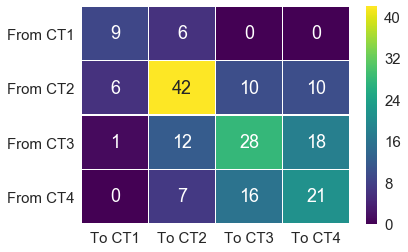

In [6]:
# determine ct transitions
transitions = pd.read_csv('data/ct_transitions.csv', index_col=0).values
sns.heatmap(steps2df(transitions), annot=True, cmap='viridis', linewidths=0.5)
plt.savefig('figures/transitions_table.pdf', bbox_inches='tight')
plt.show()

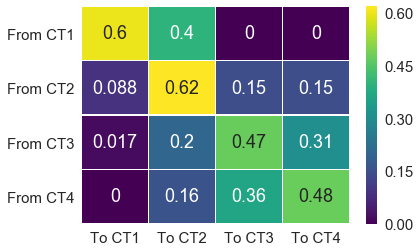

In [7]:
# convert transitions matrix to probability matrix
probs = normalize_probs(transitions)
sns.heatmap(steps2df(probs), annot=True, cmap='viridis', linewidths=0.5)
plt.savefig('figures/probs_table.pdf', bbox_inches='tight')
plt.show()

In [8]:
# convert probability matrix to pykov chain, find steady state
chain = probs2chain(probs)
freq_steady = chain2steady(chain, printbool=True)

CT1 : 0.09094283593170009
CT2 : 0.3575847562484534
CT3 : 0.28470675575352644
CT4 : 0.26676565206632014


### Average step counts

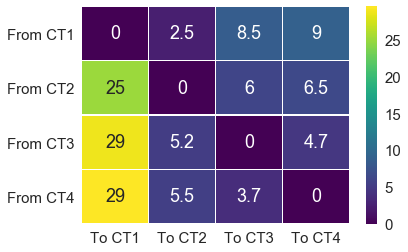

In [9]:
# calculate average step count to transition between states
step_mat = chain2steps(chain)
step_df = steps2df(step_mat)
sns.heatmap(step_df, annot=True, cmap='viridis', linewidths=0.5)
plt.savefig('figures/steps_table.pdf', bbox_inches='tight')
plt.show()

### Plot Timecourse to Equilibrium

<Figure size 432x288 with 0 Axes>

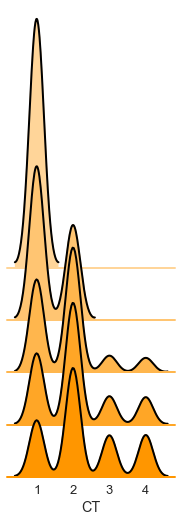

<Figure size 432x288 with 0 Axes>

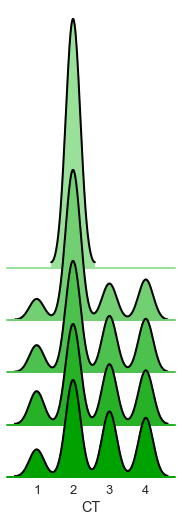

<Figure size 432x288 with 0 Axes>

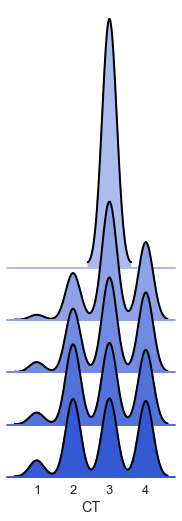

<Figure size 432x288 with 0 Axes>

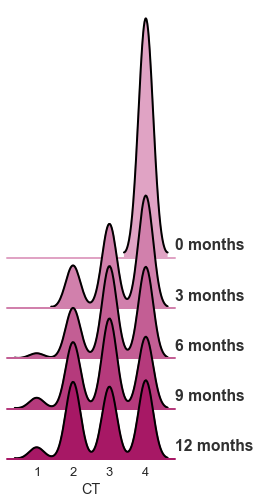

In [14]:
# sample data starting from various cts
sns.set(font_scale=1.3, style='white',rc={"axes.facecolor": (0, 0, 0, 0)})

def label(x, color, label):
    ax = plt.gca()
    ax.text(1, .05, str(int(label)*3)+' months', fontweight="bold", color='#303030',
            ha="left", va="center", transform=ax.transAxes)
    
for e,vector in enumerate([pykov.Vector(CT1=1), pykov.Vector(CT2=1), pykov.Vector(CT3=1), pykov.Vector(CT4=1)]):
    timepoints, samplesize = 5, 1000
    ct_timecourse = pd.DataFrame(0, index=range(timepoints*samplesize), columns=['timepoint','samples'])
    for t in range(timepoints):
        samples = np.random.choice(range(1,5), p=vector2list(chain.pow(vector, t)), size=samplesize)
        ct_timecourse.iloc[samplesize*t:samplesize*(t+1),0] = [t for i in range(samplesize)]
        ct_timecourse.iloc[samplesize*t:samplesize*(t+1),1] = samples
    plt.figure()
    g = sns.FacetGrid(ct_timecourse, row="timepoint", hue="timepoint", \
                      size=1.5, aspect=2, palette=sns.light_palette(COLORS[e], n_colors=7)[2:])
    g.map(sns.kdeplot, 'samples', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, 'samples', clip_on=False, color="k", lw=2, bw=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)
    if e==3:
        g.map(label, 'samples')
    g.fig.subplots_adjust(hspace=-.8)
    g.set_titles("")
    g.set(yticks=[])
    g.set(xticks=range(1,5))
    g.despine(bottom=True, left=True)
    plt.xlabel('CT')
    plt.savefig('figures/ct'+str(e+1)+'densitytimeline.pdf', bbox_inches='tight')
    plt.show()

In [18]:
# find distributions after timesteps
ct1 = pykov.Vector(CT1=1)
ct1_0 = vector2list(chain.pow(ct1, 0))
ct1_6 = vector2list(chain.pow(ct1, 1))
ct1_12 = vector2list(chain.pow(ct1, 2))
ct1_24 = vector2list(chain.pow(ct1, 4))

ct2 = pykov.Vector(CT2=1)
ct2_0 = vector2list(chain.pow(ct2, 0))
ct2_6 = vector2list(chain.pow(ct2, 1))
ct2_12 = vector2list(chain.pow(ct2, 2))
ct2_24 = vector2list(chain.pow(ct2, 4))

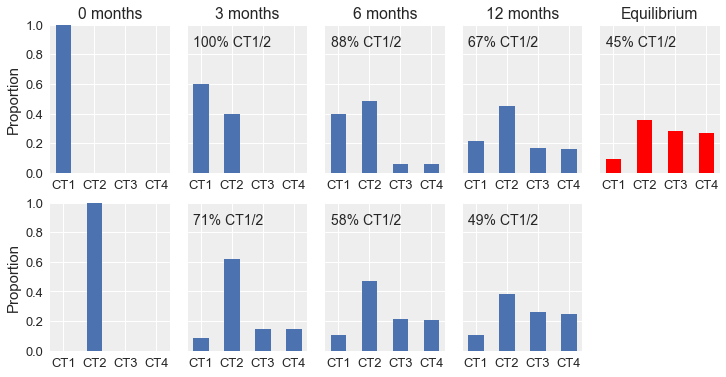

In [19]:
# plot timestep distributions
data = [ct1_0, ct1_6, ct1_12, ct1_24, \
        freq_steady, \
        ct2_0, ct2_6, ct2_12, ct2_24]

ind = np.arange(4)
width = .5
ctlabels = ['CT1', 'CT2', 'CT3', 'CT4']
plt.figure(figsize=(12,6))
matplotlib.rcParams.update({'font.size': 14})
gs = gridspec.GridSpec(2, 5)
gs.update(wspace=0.15, hspace=0.2)
for i in range(10):
    if i!=9:
        ax = plt.subplot(gs[i])
        plt.axis('on')
        if i==4:
            ax.bar(ind, data[i], width, color='r')
        else:
            ax.bar(ind, data[i], width)
        if i==0 or i==5:
            ax.set_ylabel('Proportion', fontsize=15)
        else:
            ax.set_yticklabels([])
            ax.text(-.25,.85,str(int(round(100*(data[i][0]+data[i][1]))))+'% CT1/2')
        ax.set_xticks(ind)
        ax.set_xticklabels(ctlabels)
        ax.set_ylim([0,1])
        if i==0:
            ax.set_title('0 months')
        elif i==1:
            ax.set_title('3 months')
        elif i==2:
            ax.set_title('6 months')
        elif i==3:
            ax.set_title('12 months')
        elif i==4:
            ax.set_title('Equilibrium')
        prettify_ax(ax)
        
plt.savefig('figures/timeline.pdf', bbox_inches='tight')
plt.show()

### Compare steady distribution to empirical data

In [15]:
# published - Gossman et al. Immunity, 2017.
'''
markov equilibrium:
CT1 : 9.1%
CT2 : 35.8%
CT3 : 28.5%
CT4 : 26.7%
'''
gossman_steady = [.097, .314, .288, .297]

In [17]:
bootstrap_samples = bootstrap(transitions)
bootstrap_sd = [np.std([a[i] for a in bootstrap_samples]) for i in range(4)]

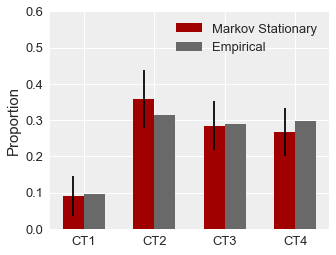

In [22]:
# plot markov and empirical comparison
ind = np.arange(4)
width = 0.3

fig, ax = simple_ax(figsize=(5,4))
matplotlib.rcParams.update({'font.size': 14})
rects1 = ax.bar(ind, freq_steady, width, color='#A00000', yerr=bootstrap_sd)
rects2 = ax.bar(ind + width, gossman_steady, width, color='#696969')

ax.set_ylabel('Proportion', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('CT1', 'CT2', 'CT3', 'CT4'))
ax.set_ylim([0,0.6])
ax.legend((rects1[0], rects2[0]), ('Markov Stationary', 'Empirical'))

#plt.savefig('figures/markov_vs_empirical.pdf', bbox_inches='tight')
plt.show()

### Chi Square Goodness of Fit Test

In [24]:
# chi-sq goodness of fit test
N = np.sum(transitions)
stats.power_divergence([int(N*a) for a in freq_steady], [int(N*b) for b in gossman_steady])

Power_divergenceResult(statistic=1.9990838771580477, pvalue=0.572596870973834)

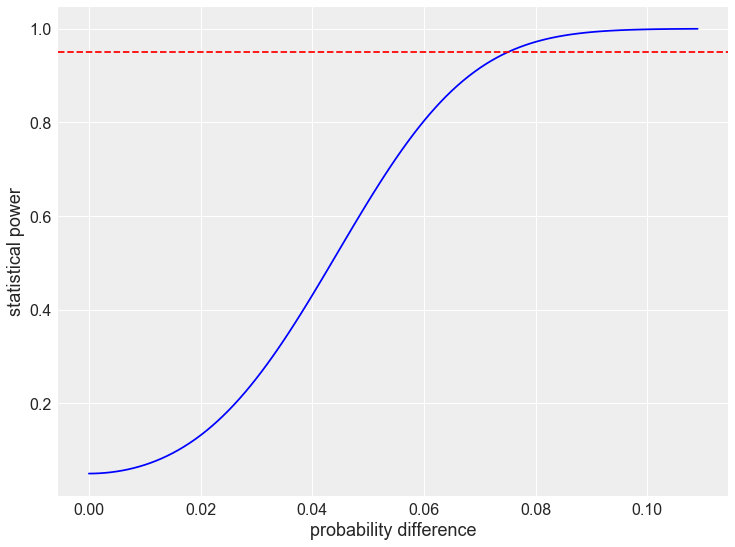

In [25]:
# power calculation
def prob2omega(p):
    ''' calculate cohens omega effect size from a probability difference '''
    w = np.sqrt(sum([p*p/gossman_steady[i] for i in range(4)]))
    return w

ps = np.arange(0,.11,.001)
omegas = [prob2omega(p) for p in ps]
%Rpush omegas
%R library(pwr)
%R calc = pwr.chisq.test(w=omegas,N=150,df=3,sig.level=.05)
%R powers = calc$power
%Rpull powers

matplotlib.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)  
f,a = simple_ax(figsize=(12,9))
plt.plot(ps, powers, c='b')
plt.axhline(.95, c='r', linestyle='--')
plt.xlabel('probability difference')
plt.ylabel('statistical power')
plt.savefig('figures/statistical_power.pdf', bbox_inches='tight')
plt.show()

### Probability preference

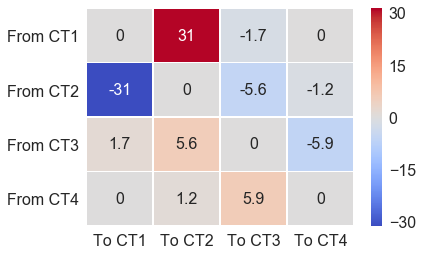

In [26]:
flux = np.zeros((4,4))
for ctA in range(4):
        for ctB in range(4):
            ctA_to_B = probs[ctA,ctB]
            ctB_to_A = probs[ctB,ctA]
            net_ct = ctA_to_B - ctB_to_A
            flux[ctA,ctB] = net_ct

sns.heatmap(steps2df(100*flux), annot=True, cmap='coolwarm', linewidths=0.5)
plt.savefig('figures/flux_table.pdf', bbox_inches='tight')
plt.show()

### Vary CT transition block rates and boost rates

In [31]:
# varying CT transitions along on
ctpairs = [(1,2), (1,3), (1,4), (3,4), (2,3), (2,4)]
target_transitions = []
for ctA,ctB in ctpairs:
    pts = []
    for blockrate in np.arange(0,1.01,.005):
        for boostrate in np.arange(0,1.01,.005):
            blocked_probs = np.copy(probs)
            blocked_probs[ctA-1,ctA-1] = probs[ctA-1,ctA-1] + blockrate*probs[ctA-1,ctB-1]
            blocked_probs[ctA-1,ctB-1] = probs[ctA-1,ctB-1] - blockrate*probs[ctA-1,ctB-1]
            blocked_probs[ctB-1,ctA-1] = probs[ctB-1,ctA-1] + boostrate*probs[ctB-1,ctB-1]
            blocked_probs[ctB-1,ctB-1] = probs[ctB-1,ctB-1] - boostrate*probs[ctB-1,ctB-1]
            chaincurr = probs2chain(blocked_probs)
            steadycurr = chain2steady(chaincurr)
            ct1eq_foldchange = steadycurr[0]/freq_steady[0]
            if ct1eq_foldchange == 0:
                pt = (blockrate, boostrate, pts[-1][2]) #singularity, use nearest point
                pts.append(pt)
            else:
                pt = (blockrate, boostrate, ct1eq_foldchange)
                pts.append(pt)
    target_transitions.append(pts)

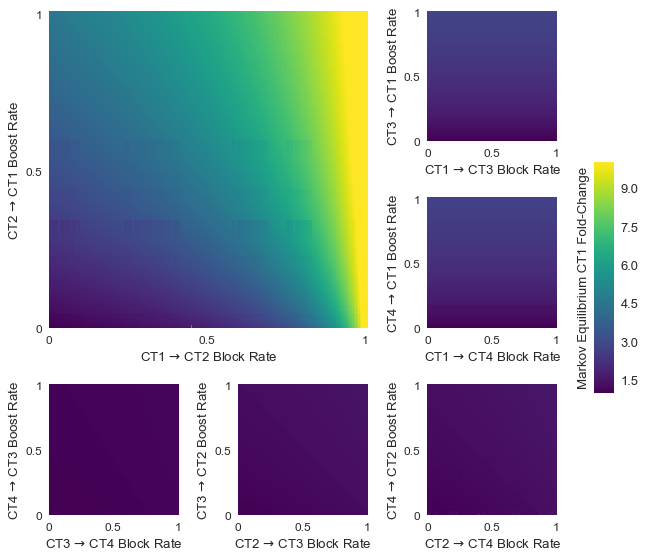

In [33]:
fig = plt.figure(figsize=(9,8))
gs = gridspec.GridSpec(3,3)
cbar_ax = fig.add_axes([.93, .3, .03, .4])
sns.set(font_scale=1.2)

for i in range(6):
    grid_row = min(i-1,2)
    grid_col = -1 if i<3 else i-3
    ax = gs[:-1,:-1] if i==0 else gs[grid_row,grid_col]
    ax = plt.subplot(ax)
    unzipped = zip(*target_transitions[i])
    ctA, ctB = ctpairs[i]
    xlabel = 'CT' + str(ctA) + ' ' + r'$\to$' + ' ' + 'CT' + str(ctB) +  ' Block Rate'
    ylabel = 'CT' + str(ctB) + ' ' + r'$\to$' + ' ' + 'CT' + str(ctA) +  ' Boost Rate'
    hm_df = pd.DataFrame({xlabel:unzipped[0], ylabel:unzipped[1], 'Z':unzipped[2]})
    hm_df = hm_df.pivot(ylabel, xlabel, 'Z')
    hm = sns.heatmap(hm_df, ax=ax, cbar=(i==0), vmin=1, vmax=10, cbar_ax=(None if i else cbar_ax), \
                     cbar_kws={'label': 'Markov Equilibrium CT1 Fold-Change'}, \
                     cmap='viridis')
    hm.invert_yaxis()
    ax.set_xticks([0,100,200])
    ax.set_yticks([0,100,200])
    ax.set_xticklabels(['0','0.5','1'], rotation='horizontal')
    ax.set_yticklabels(['0','0.5','1'])
    if i==0:
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('left')
        cbar_ax.tick_params(labelsize=13)
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('figures/boostblock.pdf', bbox_inches='tight')
plt.show()

In [29]:
# now vary CT transition rates merging CT2/3/4
pts = []
for blockrate in np.arange(0,1.01,.0025):
    for boostrate in np.arange(0,1.01,.0025):
        blocked_probs = np.zeros((4,4))
        blocked_probs[0,1:] = probs[0,1:] - blockrate*probs[0,1:]
        blocked_probs[0,0] = probs[0,0] + np.sum(blockrate*probs[0,1:])
        blocked_probs[1:,1:] = probs[1:,1:] - boostrate*probs[1:,1:]
        blocked_probs[1:,0] = probs[1:,0] + np.sum(boostrate*probs[1:,1:], axis=1)
        chaincurr = probs2chain(blocked_probs)
        steadycurr = chain2steady(chaincurr)
        if steadycurr[0]==0 and steadycurr[1]==0: #singularity, use nearest point
            pt = (blockrate, boostrate, pts[-1][2], pts[-1][3])
            pts.append(pt)
        elif steadycurr[0]==0:
            pt = (blockrate, boostrate, pts[-1][2], steadycurr[1])
            pts.append(pt)
        elif steadycurr[1]==0:
            pt = (blockrate, boostrate, steadycurr[0], pts[-1][3])
            pts.append(pt)
        else:
            pt = (blockrate, boostrate, steadycurr[0], steadycurr[1])
            pts.append(pt)

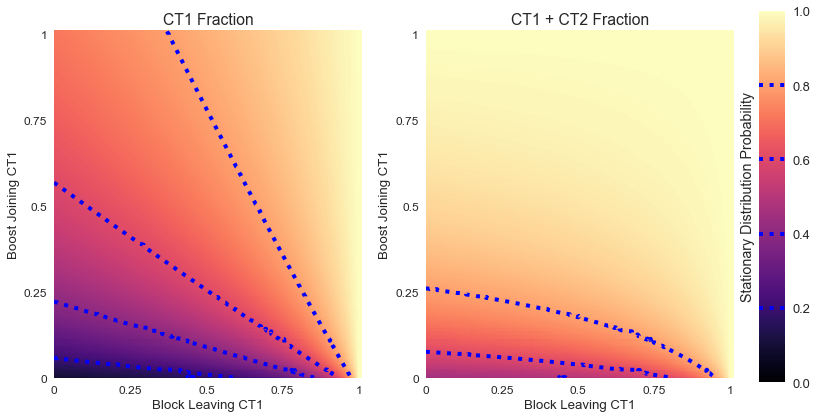

In [30]:
# plot merged
fig, axarr = plt.subplots(1,2, sharex=True, figsize=(12,6))
matplotlib.rcParams.update({'font.size': 14})
plt.rcParams["axes.labelsize"] = 13
sns.set(font_scale=1.3)
cbar_ax = fig.add_axes([.89, .105, .03, .86])

unzipped = zip(*pts)
for i in range(2):
    Z = unzipped[2] if i==0 else np.array(unzipped[2])+np.array(unzipped[3])
    hm_df = pd.DataFrame({'Block Leaving CT1':unzipped[0], 'Boost Joining CT1':unzipped[1], 'Z':Z})
    hm_df = hm_df.pivot('Boost Joining CT1', 'Block Leaving CT1', 'Z')
    hm = sns.heatmap(hm_df, ax=axarr[i], vmin=0, vmax=1, cbar=(i==0), \
                     cmap='magma', cbar_ax=(cbar_ax if i==0 else None), \
                     cbar_kws={'label': 'Stationary Distribution Probability'})
    hm.invert_yaxis()
    axarr[i].contour(hm_df, colors='b', linewidths=4, linestyles=':', levels=[.2,.4,.6,.8])
    title = 'CT1 Fraction' if i==0 else 'CT1 + CT2 Fraction'
    axarr[i].set_title(title)
    axarr[i].set_xticks([0,100,200,300,400])
    axarr[i].set_yticks([0,100,200,300,400])
    axarr[i].set_xticklabels(['0','0.25','0.5','0.75','1'], rotation='horizontal')
    axarr[i].set_yticklabels(['0','0.25','0.5','0.75','1'])       
cbar_ax.hlines([.2,.4,.6,.8], [0 for i in range(4)], [1 for i in range(4)], colors='b', linewidth=4, linestyles=':')
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('left')
fig.tight_layout(rect=[0, 0, .88, 1])
plt.savefig('figures/combined_boostblock.pdf', bbox_inches='tight')
plt.show()